In [1]:

!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/andrewmvd/animal-faces")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: Legendary
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/andrewmvd/animal-faces


100%|██████████| 696M/696M [00:03<00:00, 213MB/s]


In [2]:
import torch
from torch import nn
from torch.optim import Adam
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np
import os

device = "cuda" if torch.cuda.is_available() else "cpu" # detect the GPU if any, if not use CPU
print("Device available: ", device)

Device available:  cuda


In [3]:
image_path = []
labels = []

for i in os.listdir("/content/animal-faces/afhq/"):
  for label in os.listdir(f"/content/animal-faces/afhq/{i}"):
    for image in os.listdir(f"/content/animal-faces/afhq/{i}/{label}"):
      labels.append(label) # Append/Put this label in the list
      image_path.append(f"/content/animal-faces/afhq/{i}/{label}/{image}")

data_df = pd.DataFrame(zip(image_path, labels), columns = ['image_paths', 'labels'])
data_df.head() # Visualizing the first 5 rows

,image_paths,labels
0,/content/animal-faces/afhq/train/cat/pixabay_c...,cat
1,/content/animal-faces/afhq/train/cat/pixabay_c...,cat
2,/content/animal-faces/afhq/train/cat/pixabay_c...,cat
3,/content/animal-faces/afhq/train/cat/pixabay_c...,cat
4,/content/animal-faces/afhq/train/cat/pixabay_c...,cat


In [5]:
#data splitting, using sampling instead of custom train_test_split
train=data_df.sample(frac=0.8,random_state=7)
test=data_df.drop(train.index)

val=test.sample(frac=0.5,random_state=7)
test=test.drop(val.index)

In [6]:
label_encoder = LabelEncoder()
label_encoder.fit(data_df['labels'])

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float)
    ])

In [7]:

class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.labels = torch.tensor(label_encoder.transform(dataframe['labels'])).to(device)

    def __len__(self):
        return self.dataframe.shape[0]

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
          image = self.transform(image).to(device)

        return image, label

In [8]:
train_dataset = CustomImageDataset(dataframe=train, transform=transform)
val_dataset = CustomImageDataset(dataframe=val, transform=transform)
test_dataset = CustomImageDataset(dataframe=test, transform=transform)

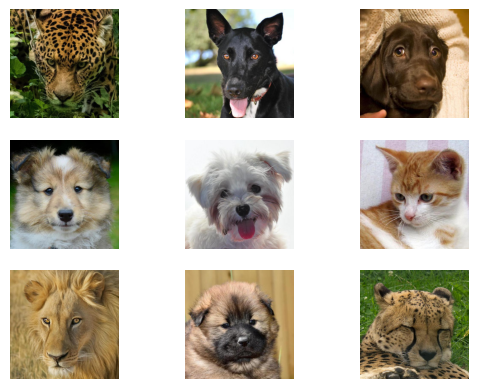

In [10]:
#visualization

n_rows = 3
n_cols = 3
f, axarr = plt.subplots(n_rows, n_cols)
for row in range(n_rows):
    for col in range(n_cols):
      image = Image.open(data_df.sample(n = 1)['image_paths'].iloc[0]).convert("RGB")
      axarr[row, col].imshow(image)
      axarr[row, col].axis('off')

plt.show()

In [11]:
#hyperparameter
LR = 1e-4
BATCH_SIZE = 16
EPOCHS = 10

In [13]:
#Dataloader

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [14]:
class Net(nn.Module):
    def __init__(self):
      super().__init__()

      self.conv1 = nn.Conv2d(3, 32, kernel_size = 3, padding = 1) # First Convolution layer
      self.conv2 = nn.Conv2d(32, 64, kernel_size = 3, padding = 1) # Second Convolution layer
      self.conv3 = nn.Conv2d(64, 128, kernel_size = 3, padding = 1) # Third Convolution layer
      self.pooling = nn.MaxPool2d(2,2) # The pooling layer, we will be using the same layer after each conv2d.
      self.relu = nn.ReLU() # ReLU Activation function

      self.flatten = nn.Flatten() # Flatten and vectorize the output feature maps that somes from the final convolution layer.
      self.linear = nn.Linear((128 * 16 * 16), 128) # Traditional Dense (Linear)
      self.output = nn.Linear(128, len(data_df['labels'].unique())) # Output Linear Layer


    def forward(self, x):
      x = self.conv1(x) # -> Outputs: (32, 128, 128)
      x = self.pooling(x)# -> Outputs: (32, 64, 64)
      x = self.relu(x)
      x = self.conv2(x) # -> Outputs: (64, 64, 64)
      x = self.pooling(x) # -> Outputs: (64, 32, 32)
      x = self.relu(x)
      x = self.conv3(x) # -> Outputs: (128, 32, 32)
      x = self.pooling(x) # -> Outputs: (128, 16, 16)
      x = self.relu(x)
      x = self.flatten(x)
      x = self.linear(x)
      x = self.output(x)

      return x

model = Net().to(device)

In [15]:
from torchsummary import summary
summary(model, input_size = (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
         MaxPool2d-2           [-1, 32, 64, 64]               0
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          18,496
         MaxPool2d-5           [-1, 64, 32, 32]               0
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 32, 32]          73,856
         MaxPool2d-8          [-1, 128, 16, 16]               0
              ReLU-9          [-1, 128, 16, 16]               0
          Flatten-10                [-1, 32768]               0
           Linear-11                  [-1, 128]       4,194,432
           Linear-12                    [-1, 3]             387
Total params: 4,288,067
Trainable params: 4,288,067
Non-trainable params: 0
---------------------------

In [16]:
criterion = nn.CrossEntropyLoss() #Loss function
optimizer = Adam(model.parameters(), lr=LR) #optimizer

In [17]:

total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []


for epoch in range(EPOCHS):
  total_acc_train = 0
  total_loss_train = 0
  total_loss_val = 0
  total_acc_val = 0

  for inputs, labels in train_loader:
    optimizer.zero_grad()
    outputs = model(inputs)
    train_loss = criterion(outputs, labels)
    total_loss_train += train_loss.item()
    train_loss.backward()

    train_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
    total_acc_train += train_acc
    optimizer.step()

  with torch.no_grad():
    for inputs, labels in val_loader:
      outputs = model(inputs)
      val_loss = criterion(outputs, labels)
      total_loss_val += val_loss.item()

      val_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
      total_acc_val += val_acc

  total_loss_train_plot.append(round(total_loss_train/1000, 4))
  total_loss_validation_plot.append(round(total_loss_val/1000, 4))
  total_acc_train_plot.append(round(total_acc_train/(train_dataset.__len__())*100, 4))
  total_acc_validation_plot.append(round(total_acc_val/(val_dataset.__len__())*100, 4))
  print(f'''Epoch {epoch+1}/{EPOCHS}, Train Loss: {round(total_loss_train/100, 4)} Train Accuracy {round((total_acc_train)/train_dataset.__len__() * 100, 4)}
              Validation Loss: {round(total_loss_val/100, 4)} Validation Accuracy: {round((total_acc_val)/val_dataset.__len__() * 100, 4)}''')
  print("="*25)

Epoch 1/10, Train Loss: 3.5027 Train Accuracy 82.5635
              Validation Loss: 0.2327 Validation Accuracy: 92.0025
Epoch 2/10, Train Loss: 1.5302 Train Accuracy 93.2657
              Validation Loss: 0.158 Validation Accuracy: 94.2963
Epoch 3/10, Train Loss: 1.0278 Train Accuracy 95.389
              Validation Loss: 0.1296 Validation Accuracy: 95.3503
Epoch 4/10, Train Loss: 0.7143 Train Accuracy 96.8382
              Validation Loss: 0.1009 Validation Accuracy: 96.3422
Epoch 5/10, Train Loss: 0.5147 Train Accuracy 97.8224
              Validation Loss: 0.098 Validation Accuracy: 96.5902
Epoch 6/10, Train Loss: 0.3812 Train Accuracy 98.3029
              Validation Loss: 0.1058 Validation Accuracy: 96.0322
Epoch 7/10, Train Loss: 0.2775 Train Accuracy 98.8143
              Validation Loss: 0.1004 Validation Accuracy: 96.7142
Epoch 8/10, Train Loss: 0.1859 Train Accuracy 99.3025
              Validation Loss: 0.1251 Validation Accuracy: 96.0942
Epoch 9/10, Train Loss: 0.1493 Trai

In [19]:
#testing on test data
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0
  for inputs, labels in test_loader:
    predictions = model(inputs)

    acc = (torch.argmax(predictions, axis = 1) == labels).sum().item()
    total_acc_test += acc
    test_loss = criterion(predictions, labels)
    total_loss_test += test_loss.item()

print(f"Accuracy Score is: {round((total_acc_test/test_dataset.__len__()) * 100, 4)} and Loss is {round(total_loss_test/1000, 4)}")


Accuracy Score is: 96.6522 and Loss is 0.0134


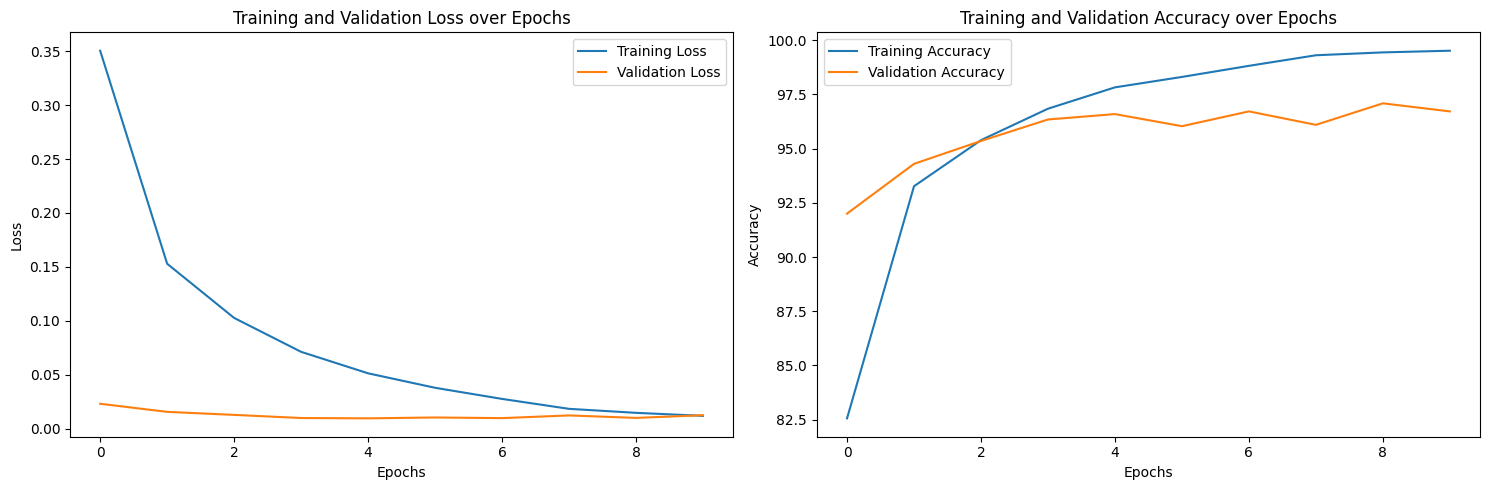

In [20]:
#plotting to visualize our model behavior during training
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].plot(total_loss_validation_plot, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].plot(total_acc_validation_plot, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.tight_layout()

plt.show()

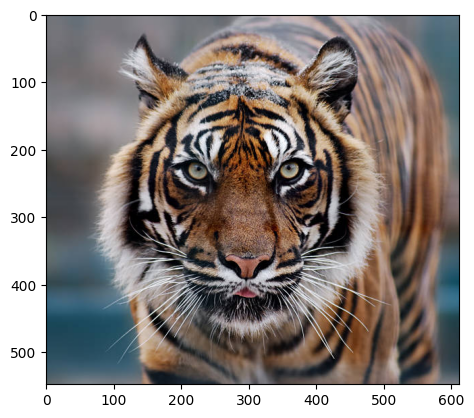


Prediction: 



array(['wild'], dtype=object)

In [22]:
#inference
def predict_image(image_path):
  image = Image.open(image_path).convert('RGB')
  image = transform(image).to(device)

  output = model(image.unsqueeze(0))
  output = torch.argmax(output, axis = 1).item()
  return label_encoder.inverse_transform([output])

## Visualize the image
image = Image.open("/content/istockphoto-170616275-612x612-tiger.jpg")
plt.imshow(image)
plt.show()


## Predict
print()
print("Prediction: \n")
predict_image("/content/istockphoto-170616275-612x612-tiger.jpg")